# RT-TDHF with MO Coefficients

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf_interface import *

π = np.pi
α = 0.007297352
c = 1.0/α
np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

In [3]:
Z_LiHa = np.array(["H ", 'Li'])
R_LiHa = np.array([[0.0000,   0.0000,    0.0000], [0.0000,   0.0000,   1.6]])

### Hydrogen cyanide / HCN
Z_HCN = np.array(["N", "C", "H"])
R_HCN = np.array([[-0.5800,    0.0000,    0.0000],
              [ 0.5800,    0.0000,    0.0000],
              [ 1.6450,    0.0000,    0.0000]])

### Hydroxide
Z_OH = np.array(["O", "H"])
R_OH = np.array([[ 0., 0., 3.], [0., 0., 2.]])

### Formaldehyide
Z_LiH = np.array(["O", "C", "H", "H"])
R_LiH = np.array([[ 0.6123,    0.0000,    0.0000],
                   [-0.6123,    0.0000,    0.0000],
                   [-1.2000,    0.2426,   -0.8998],
                   [-1.2000,   -0.2424,    0.8998]])

Z_urea = np.array(["N", "C", "N", "O", "H", "H", "H", "H"])
R_urea = np.array([[ 1.3308,     -0.3250,     -0.0930],
                   [-0.0155,      0.0630,     0.0071],
                   [-1.0241,     -0.9132,     -0.0464],
                   [-0.3102,      1.2521,      0.1409],
                   [ 1.5932,     -1.2730,     -0.2006],
                   [ 2.0400,      0.3650,     -0.0547],
                   [-1.9724,     -0.6371,      0.0242],
                   [-0.8142,     -1.8744,     -0.1532]])

Z_Aspirin = np.array(["O", "O", "O", "O", "C", "C",  "C",  "C",  "C",  "C",  "C",  "C",  "C",  "H", "H", "H", "H", "H", "H", "H", "H"])
R_Aspirin = np.array([[3.7320,   -0.0600,    0.0000],
              [6.3301,    1.4400,    0.0000],
              [4.5981,    1.4400,    0.0000],
              [2.8660,   -1.5600,    0.0000],
              [4.5981,   -0.5600,    0.0000],
              [5.4641,   -0.0600,    0.0000],
              [4.5981,   -1.5600,    0.0000],
              [6.3301,   -0.5600,    0.0000],
              [5.4641,   -2.0600,    0.0000],
              [6.3301,   -1.5600,    0.0000],
              [5.4641,    0.9400,    0.0000],
              [2.8660,   -0.5600,    0.0000],
              [2.0000,   -0.0600,    0.0000],
              [4.0611,   -1.8700,    0.0000],
              [6.8671,   -0.2500,    0.0000],
              [5.4641,   -2.6800,    0.0000],
              [6.8671,   -1.8700,    0.0000],
              [2.3100,    0.4769,    0.0000],
              [1.4631,    0.2500,    0.0000],
              [1.6900,   -0.5969,    0.0000],
              [6.3301,    2.0600,    0.0000]])

asd = pyscf_UHF()
#asd.initialize(xyz=R_HCN, Z=Z_HCN, charge=0, basis="crenbl") ###lanl2dz
### ''' Na 0. 0. 0.; H  0.  0.  1.'''
mol = gto.M(atom='''
 Li 0. 0. 0.
 H  0.  0.  1.6''',
            basis={'Na':'lanl2dz', "Li": "sto-3g", 'H':'sto-3g'},
            ecp = {'Na': gto.basis.parse_ecp('''
Na nelec 10
Na ul
0      2.0000000              6.0000000        
1    175.5502590            -10.0000000        
2      2.3365719             -6.0637782        
2      0.7799867             -0.7299393        
Na S
0    243.3605846              3.0000000        
1     41.5764759             36.2847626        
2     13.2649167             72.9304880        
2      0.9764209              6.0123861        
Na P
0   1257.2650682              5.0000000        
1    189.6248810            117.4495683        
2     54.5247759            423.3986704        
2      0.9461106              7.1241813        
''')})



asd.pyscf_mol = mol

(asd.pyscf_mol).intor("ECPscalar")

asd.Calc() #Calc(self)


asd.Ca = asd.Cb

converged SCF energy = -7.86186476980865  <S^2> = 3.7747583e-15  2S+1 = 1


In [5]:
asd.Ca

array([[ 0.9913, -0.1671, -0.21  , -0.    ,  0.    ,  0.0935],
       [ 0.0327,  0.4552,  0.7995,  0.    ,  0.    , -0.7027],
       [-0.    , -0.    , -0.    ,  0.9973,  0.0733,  0.    ],
       [ 0.    ,  0.    ,  0.    , -0.0733,  0.9973,  0.    ],
       [-0.0063,  0.346 , -0.6121, -0.    ,  0.    , -0.9795],
       [ 0.0044,  0.5491, -0.1402,  0.    , -0.    ,  1.1847]])

Let's first define an Electric field:

In [3]:
field3 = E_field()
field3.E0 = 1e-5
field3.ω  = 0.25
field3.Γ  = 1.
field3.vector = np.array([0,0,1]) #np.ones(3)

This is a simple RT-TDHF integrator with the MO coefficients

In [7]:
def RT_UT_C(uhf_object, CA_t=None, CB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    tsteps = int(dT/dt)
    
    if CA_t is None:
        CA_t = 1.*(uhf_object.Ca).astype(complex)
    if CB_t is None:
        CB_t = 1.*(uhf_object.Cb).astype(complex)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    CAd_t = 1.*((uhf_object.Ca).astype(complex)).T
    CBd_t = 1.*((uhf_object.Cb).astype(complex)).T
    Na = uhf_object.Na
    Nb = uhf_object.Nb
    Unit = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = (step) * dt
        
        # get AO density matrices
        DA_ao = np.einsum("Ai, iB -> AB", CA_t[:,:Na], CAd_t[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", CB_t[:,:Nb], CBd_t[:Nb, :])
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        # compute FA, FB and transform to MO basis
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FA = (CAd_t) @ FA_ao @ (CA_t) 
        FB = (CBd_t) @ FB_ao @ (CB_t)
            
        # compute propagators
        UA  = Expm( -1j*(dt)*FA )
        UB  = Expm( -1j*(dt)*FB )
        
        ### full step forward
        CA_t  = CA_t @ (UA)
        CB_t  = CB_t @ (UB)
        CAd_t = (UA).conj().T @ CAd_t
        CBd_t = (UB).conj().T @ CBd_t
        
        Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, Unit

t, d_tx, UU = RT_UT_C(asd, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [11:35<00:00, 719.18it/s]


Let's look at the dynamic Dipole moment:

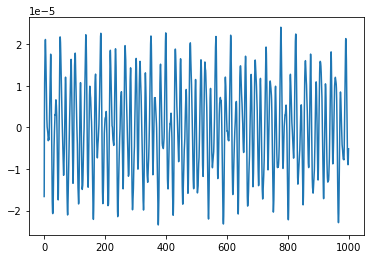

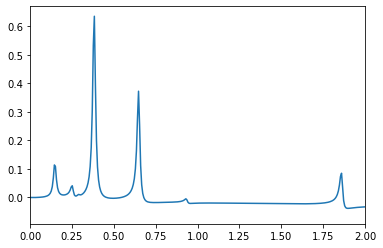

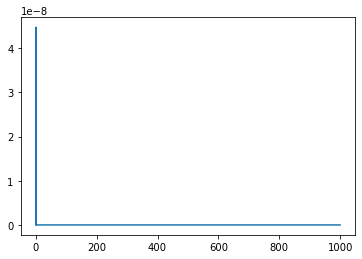

In [8]:
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
plt.plot(ω, - (1/4/np.pi/np.sqrt(2*np.pi))* np.einsum("w, wx -> w", ω, d_ωx.imag)/field3.E0)
plt.xlim([0,2])
plt.show()

plt.plot(t, UU)
plt.show()

In [32]:
asd.basis

'sto-3g'

In [10]:
def RT_UT_TC(uhf_object, CA_t=None, CB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    tsteps = int(dT/dt)
    
    if CA_t is None:
        CA_t = 1.*(uhf_object.Ca).astype(complex)
    if CB_t is None:
        CB_t = 1.*(uhf_object.Cb).astype(complex)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    CAd_t = 1.*((uhf_object.Ca).astype(complex)).T
    CBd_t = 1.*((uhf_object.Ca).astype(complex)).T
    Na = uhf_object.Na
    Nb = uhf_object.Nb
    Unit = np.zeros(tsteps)
    Eng  = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = (step) * dt
        
        # get AO density matrices
        DA_ao = np.einsum("Ai, iB -> AB", CA_t[:,:Na], CAd_t[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", CB_t[:,:Nb], CBd_t[:Nb, :])
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        # compute FA, FB and transform to MO basis
        FA_ao, FB_ao = uhf_object.get_UCFockSS(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FA = (CAd_t) @ FA_ao @ (CA_t) 
        FB = (CBd_t) @ FB_ao @ (CB_t)
        
        Eng[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        
        # compute propagators
        UA  = Expm2( -1j*(dt)*FA )
        UB  = Expm2( -1j*(dt)*FB )
        
        ### full step forward
        CA_t  = CA_t @ (UA)
        CB_t  = CB_t @ (UB)
        CAd_t = (UA).conj().T @ CAd_t
        CBd_t = (UB).conj().T @ CBd_t
        
        Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
    
        if step == 0:
            print(Unit[step])
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, Unit, Eng

t, d_tx, UU, Eng = RT_UT_TC(asd, dt = 0.002, dT =1000, field=field3)
t, d_txaa, UUaa = RT_UT_C(asd, dt = 0.002, dT =1000, field=field3)

  0%|          | 1601/500000 [00:00<01:01, 8125.86it/s]

7.907728711242412e-11


100%|██████████| 500000/500000 [03:09<00:00, 2634.00it/s]


ValueError: x and y must have same first dimension, but have shapes (1,) and (500000,)

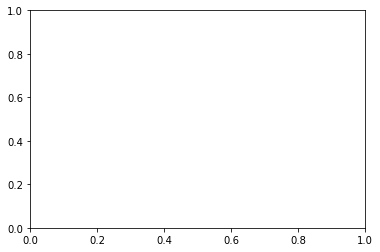

In [38]:
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
ω, d_ωxaa = RT_FFT(t, d_txaa, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag))
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωxaa.imag))
plt.xlim([0,2])
plt.show()

plt.plot(t, UU)
plt.show()

plt.plot(t, Eng)
plt.show()

In [111]:
np.argmax(Eng)

0

In [26]:
asd.basis

'cc-pvdz'

Only if Eigenvalues are small can this trucated series converge!!

In [86]:
dt = 0.02
yo = Expm(1j * np.diag(asd.Ea) * dt)
to = trucatedexpm(1j * np.diag(asd.Ea) * dt)
np.allclose(yo, to)

True

In [59]:
asd.Ea

array([-15.6317, -11.3152,  -1.2673,  -0.8112,  -0.5763,  -0.5029,  -0.5029,   0.1587,   0.1587,   0.2308,   0.4277,   0.4683,   0.4683,   0.5576,   0.6681,   0.7934,   0.7934,   1.1448,   1.4326,
         1.7178])

In [91]:
mol = gto.M(atom='''
 Na 0. 0. 0.
 H  0.  0.  1.''',
            basis={'Na':'lanl2dz', 'H':'sto3g'},
            ecp = {'Na': gto.basis.parse_ecp('''
Na nelec 10
Na ul
0      2.0000000              6.0000000        
1    175.5502590            -10.0000000        
2      2.3365719             -6.0637782        
2      0.7799867             -0.7299393        
Na S
0    243.3605846              3.0000000        
1     41.5764759             36.2847626        
2     13.2649167             72.9304880        
2      0.9764209              6.0123861        
Na P
0   1257.2650682              5.0000000        
1    189.6248810            117.4495683        
2     54.5247759            423.3986704        
2      0.9461106              7.1241813        
''')})



asd.pyscf_mol = mol

(asd.pyscf_mol).intor("ECPscalar")

array([[ 0.0497, -0.0223,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.0402],
       [-0.0223,  0.1338,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.248 ],
       [ 0.    ,  0.    ,  0.012 ,  0.    ,  0.    ,  0.0046,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.012 ,  0.    ,  0.    ,  0.0046,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.012 ,  0.    ,  0.    ,  0.0046,  0.0309],
       [ 0.    ,  0.    ,  0.0046,  0.    ,  0.    ,  0.0023,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.0046,  0.    ,  0.    ,  0.0023,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.0046,  0.    ,  0.    ,  0.0023,  0.0169],
       [-0.0402,  0.248 ,  0.    ,  0.    ,  0.0309,  0.    ,  0.    ,  0.0169,  0.5792]])

In [172]:
def RT_UT_CMag(uhf_object, CA_t=None, CB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    tsteps = int(dT/dt)
    
    if CA_t is None:
        CA_t = 1.*(uhf_object.Ca).astype(complex)
    if CB_t is None:
        CB_t = 1.*(uhf_object.Cb).astype(complex)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    CAd_t = 1.*((uhf_object.Ca).astype(complex)).T
    CBd_t = 1.*((uhf_object.Cb).astype(complex)).T
    Na = uhf_object.Na
    Nb = uhf_object.Nb
    Unit = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # get AO density matrices
        DA_ao = np.einsum("Ai, iB -> AB", CA_t[:,:Na], CAd_t[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", CB_t[:,:Nb], CBd_t[:Nb, :])
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        # compute FA, FB and transform to MO basis
        t = (step) * dt
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FA = (CAd_t) @ FA_ao @ (CA_t) 
        FB = (CBd_t) @ FB_ao @ (CB_t)
        
        t = (step + 0.5) * dt
        FAh_ao, FBh_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FAh = (CAd_t) @ FAh_ao @ (CA_t) 
        FBh = (CBd_t) @ FBh_ao @ (CB_t)
            
        # compute propagators
        UA  = Expm( -1j*(dt)*FA + ((-1j*dt/2)**2)/2 * (FA @ FAh - FAh @ FA) )
        UB  = Expm( -1j*(dt)*FB + ((-1j*dt/2)**2)/2 * (FB @ FBh - FBh @ FB) )
        
        ### full step forward
        CA_t  = CA_t @ (UA)
        CB_t  = CB_t @ (UB)
        CAd_t = (UA).conj().T @ CAd_t
        CBd_t = (UB).conj().T @ CBd_t
        
        Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, Unit

field4 = E_field()
field4.E0 = 1e-3
field4.ω  = 0.25
field4.Γ  = 1.
field4.vector = np.ones(3)
t, d_tx, UU = RT_UT_CMag(asd, dt = 0.010, dT =1000, field=field4)

100%|██████████| 100000/100000 [01:03<00:00, 1584.27it/s]


100%|██████████| 100000/100000 [00:38<00:00, 2592.62it/s]


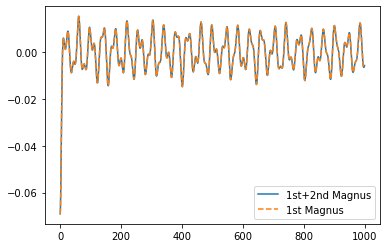

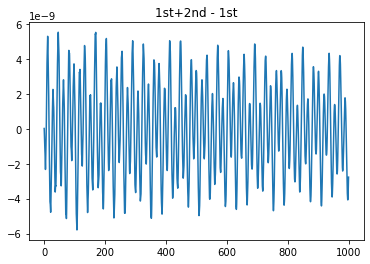

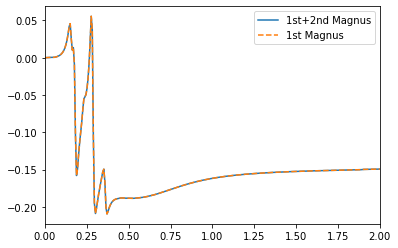

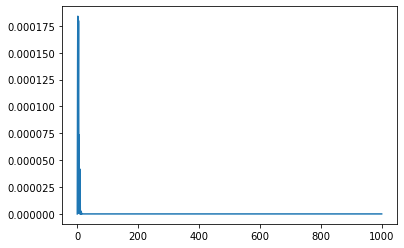

In [173]:
t, d_txreg, UUreg = RT_UT_C(asd, dt = 0.010, dT =1000, field=field4)
ωreg, d_ωxreg = RT_FFT(t, d_tx, Γ=0.01)

plt.plot(t, d_tx[:,2], label="1st+2nd Magnus")
plt.plot(t, d_txreg[:,2], label="1st Magnus", linestyle="dashed")
plt.legend()
plt.show()

plt.plot(t, d_tx[:,2]-d_txreg[:,2])
plt.title("1st+2nd - 1st")
plt.show()

ω, d_ωx = RT_FFT(t, d_txreg, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag), label="1st+2nd Magnus")
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωxreg.imag), label="1st Magnus", linestyle="dashed")
plt.xlim([0,2])
plt.legend()
plt.show()

plt.plot(t, UU)
plt.show()

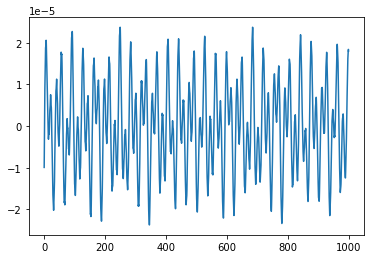

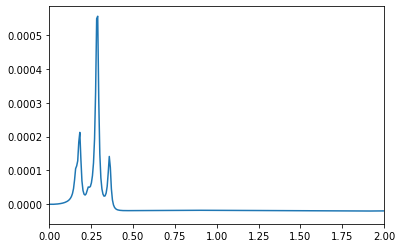

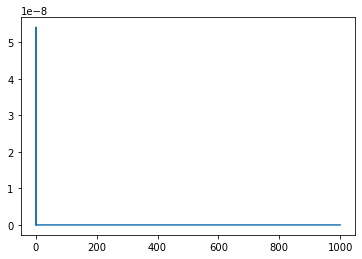

In [115]:
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag))
plt.xlim([0,2])
plt.show()

plt.plot(t, UU)
plt.show()

In [3]:
def Expm1(A): ## 1th order with 0 matrix products!!
    return np.eye(len(A)) + A

def Expm2(A): ## 2th order with 1 matrix products!!
    #return (np.eye(len(A)) + (0.5+0.5*1j)*A) @ (np.eye(len(A)) + (0.5-0.5*1j)*A)
    return np.eye(len(A)) + A + A @ A /2
    
def Expm4(A): ## 4th order with 2 matrix products!!
    A2 = A @ A
    I  = np.eye(len(A))
    return I + A + A2 @ ( I/2 + A/6 + A2/24 ) #+ A3 @ ( I/6 + A2 / 120 + A3 / 720 )

def Expm4n(A): ## 4th order
    return np.eye(len(A)) + A + A @ A/2 + A @ A @ A/6 + A @ A @ A @ A /24

def Expm6(A): ## 6th order with 3 matrix products!!
    A2 = A @ A
    A3 = A2 @ A
    I  = np.eye(len(A))
    return (I + 0.237217*A + 0.427086*A2 -0.122106* A3) @ (I + 0.762783*A -0.108031*A2 + -0.0113745*A3)

def Expm6old(A): ## 6th order with 4 matrix products!!
    A2 = A @ A
    A3 = A2 @ A
    I  = np.eye(len(A))
    return I + A + A2 @ ( I/2 + A2 /24 ) + A3 @ ( I/6 + A2 /120 + A3 /720 )

In [ ]:
A = np.random.random((1000,1000)).astype(complex)
print(A[55,55])

np.allclose(Expm6new(A), Expm6(A))


In [32]:
import time

size = 10000
A = np.random.random((size,size), dtype=complex)
print("For Matrices of size: " + str(size) + " x " + str(size))

t = time.time()
V, E = np.linalg.eig( np.random.random((size,size)) )
print( "exp diagonalization took: %4.6f s" % (time.time() - t ) )

t = time.time()
B = Expm2(A)
print( "2 matrix-products took: %4.6f s" % (time.time() - t ) )

t = time.time()
B = Expm4(A)
print( "4? matrix-products took: %4.6f s" % (time.time() - t ) )

t = time.time()
B = Expm4n(A)
print( "4n matrix-products took: %4.6f s" % (time.time() - t ) )

t = time.time()
A = Expm6(A)
print( "4 matrix-products took: %4.6f s" % (time.time() - t ) )

t = time.time()
B = A @ A @ A @ A @ A @ A @ A
print( "6 matrix-products took: %4.6f s" % (time.time() - t ) )

For Matrices of size: 10000 x 10000
exp diagonalization took: 511.310921 s
2 matrix-products took: 39.326424 s
4? matrix-products took: 78.275945 s
4n matrix-products took: 231.868428 s
4 matrix-products took: 155.048119 s
6 matrix-products took: 231.882142 s


For Matrices of size: 2000 x 2000
diagonalization took  : 5.975968 s
2 matrix-products took: 0.665325 s
4 matrix-products took: 1.259788 s
6 matrix-products took: 1.874239 s

### Lets get RCIS... 

In [ ]:
def RCIS_1p(Fock_pqt, Na):
    """ MO Fock Matrix (and occupation index) Compute 1e CIS Hamiltonian """
    A  = np.einsum('ab, ij -> iajb', Fock_pqt[Na:,Na:], np.eye( len(Fock_pqt[:Na,:Na]) ))
    A -= np.einsum('ij, ab -> iajb', Fock_pqt[:Na,:Na], np.eye( len(Fock_pqt[Na:,Na:]) ))
    
    A.shape = (Cv.shape[1]*Co.shape[1], Cv.shape[1]*Co.shape[1])
    return A

def RCIS_2p(uhf_object):
    """ Givn UHF_object Compute 2e CIS Hamiltonian """
    Na = uhf_object.Na
    Co = uhf_object.Ca[:,:Na]
    Cv = uhf_object.Ca[:,Na:]
    A  = 2 * np.einsum('Ai, Ba, Cj, Db, ABCD -> iajb', Co, Cv, Co, Cv, uhf_object.I, optimize=True)
    A -= np.einsum('Ai, Bj, Ca, Db, ABCD -> ijab', Co, Co, Cv, Cv, uhf_object.I, optimize=True).swapaxes(1, 2)
    
    A.shape = (Cv.shape[1]*Co.shape[1], Cv.shape[1]*Co.shape[1])
    return A

def RT_UT_CIS(uhf_object, CA_t=None, CB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    tsteps = int(dT/dt)
    
    if CA_t is None:
        CA_t = 1.*(uhf_object.Ca).astype(complex)
    if CB_t is None:
        CB_t = 1.*(uhf_object.Cb).astype(complex)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    CAd_t = 1.*((uhf_object.Ca).astype(complex)).T
    CBd_t = 1.*((uhf_object.Cb).astype(complex)).T
    Na = uhf_object.Na
    Nb = uhf_object.Nb
    Unit = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = (step) * dt
        
        # get AO density matrices
        DA_ao = np.einsum("Ai, iB -> AB", CA_t[:,:Na], CAd_t[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", CB_t[:,:Nb], CBd_t[:Nb, :])
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        # compute FA, FB and transform to MO basis
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FA = (CAd_t) @ FA_ao @ (CA_t) 
        FB = (CBd_t) @ FB_ao @ (CB_t)
            
        # compute propagators
        UA  = Expm( -1j*(dt)*FA )
        UB  = Expm( -1j*(dt)*FB )
        
        ### full step forward
        CA_t  = CA_t @ (UA)
        CB_t  = CB_t @ (UB)
        CAd_t = (UA).conj().T @ CAd_t
        CBd_t = (UB).conj().T @ CBd_t
        
        Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, Unit

t, d_tx, UU = RT_UT_C(asd, dt = 0.002, dT =1000, field=field3)

In [67]:
def LvN_dipole(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1_αe = -1j*(F_t_αe@DA_t - DA_t@F_t_αe)
        K1_βe = -1j*(F_t_βe@DB_t - DB_t@F_t_βe)
        
        tempD_αe = DA_t + 0.5 * dt * K1_αe
        tempD_βe = DB_t + 0.5 * dt * K1_βe
        
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K2_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        tempD_αe = DA_t + 0.5 * dt * K2_αe
        tempD_βe = DB_t + 0.5 * dt * K2_βe
        
        
        # compute K3
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K3_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K3_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        tempD_αe = DA_t + 1.0 * dt * K3_αe
        tempD_βe = DB_t + 1.0 * dt * K3_βe
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K4_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K4_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        DA_t += (dt/6.0) * (K1_αe + 2.0 * K2_αe + 2.0 * K3_αe + K4_αe) 
        DB_t += (dt/6.0) * (K1_βe + 2.0 * K2_βe + 2.0 * K3_βe + K4_βe)
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

In [68]:
t, d_tx = LvN_dipole(asd, dt = 0.02, dT =1000, field=field3)

100%|██████████| 50000/50000 [03:35<00:00, 231.49it/s]


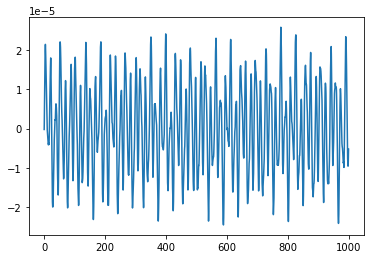

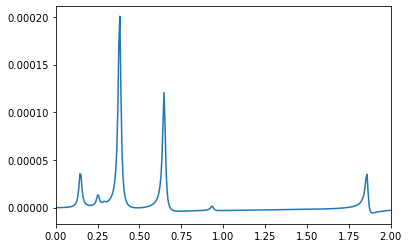

In [69]:
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag))
plt.xlim([0,2])
plt.show()

In [12]:
def LvN_dipoleCC(uhf_object, CA_t=None, CB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if CA_t is None:
        CA_t  = 1.*((uhf_object.Ca).astype(complex))
        CAd_t = 1.*((uhf_object.Ca).astype(complex)).T
    if CB_t is None:
        CB_t  = 1.*((uhf_object.Ca).astype(complex))
        CBd_t = 1.*((uhf_object.Ca).astype(complex)).T
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    Na   = uhf_object.Na
    Nb   = uhf_object.Nb
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = np.einsum("Ai, iB -> AB", CA_t[:,:Na], CAd_t[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", CB_t[:,:Nb], CBd_t[:Nb, :])
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        Fα_t = (CAd_t) @ FA_ao @ (CA_t) 
        Fβ_t = (CBd_t) @ FB_ao @ (CB_t)
        
        K1_α  =  1j*( CA_t@Fα_t )
        K1_αd = -1j*( Fα_t@CAd_t )
        K1_β  =  1j*( CB_t@Fβ_t )
        K1_βd = -1j*( Fβ_t@CBd_t )
        
        tempC_α  = CA_t  + 0.5 * dt * K1_α
        tempC_β  = CB_t  + 0.5 * dt * K1_β
        tempC_αd = CAd_t + 0.5 * dt * K1_αd
        tempC_βd = CBd_t + 0.5 * dt * K1_βd
        
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = np.einsum("Ai, iB -> AB", tempC_α[:,:Na], tempC_αd[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", tempC_β[:,:Nb], tempC_βd[:Nb, :])
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        Fα_t = (tempC_αd) @ FA_ao @ (tempC_α) 
        Fβ_t = (tempC_βd) @ FB_ao @ (tempC_β)
        
        K2_α  =  1j*( tempC_α@Fα_t )
        K2_αd = -1j*( Fα_t@tempC_αd )
        K2_β  =  1j*( tempC_β@Fβ_t )
        K2_βd = -1j*( Fβ_t@tempC_βd )
        
        tempC_α  = CA_t  + 0.5 * dt * K2_α
        tempC_β  = CB_t  + 0.5 * dt * K2_β
        tempC_αd = CAd_t + 0.5 * dt * K2_αd
        tempC_βd = CBd_t + 0.5 * dt * K2_βd
        
        # compute K3
        DA_ao = np.einsum("Ai, iB -> AB", tempC_α[:,:Na], tempC_αd[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", tempC_β[:,:Nb], tempC_βd[:Nb, :])
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        Fα_t = (tempC_αd) @ FA_ao @ (tempC_α) 
        Fβ_t = (tempC_βd) @ FB_ao @ (tempC_β)
        
        K3_α  =  1j*( tempC_α@Fα_t )
        K3_αd = -1j*( Fα_t@tempC_αd )
        K3_β  =  1j*( tempC_β@Fβ_t )
        K3_βd = -1j*( Fβ_t@tempC_βd )
        
        tempC_α  = CA_t  + 0.5 * dt * K3_α
        tempC_β  = CB_t  + 0.5 * dt * K3_β
        tempC_αd = CAd_t + 0.5 * dt * K3_αd
        tempC_βd = CBd_t + 0.5 * dt * K3_βd
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = np.einsum("Ai, iB -> AB", tempC_α[:,:Na], tempC_αd[:Na, :])
        DB_ao = np.einsum("Ai, iB -> AB", tempC_β[:,:Nb], tempC_βd[:Nb, :])
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        Fα_t = (tempC_αd) @ FA_ao @ (tempC_α) 
        Fβ_t = (tempC_βd) @ FB_ao @ (tempC_β)
        
        K4_α  =  1j*( tempC_α@Fα_t )
        K4_αd = -1j*( Fα_t@tempC_αd )
        K4_β  =  1j*( tempC_β@Fβ_t )
        K4_βd = -1j*( Fβ_t@tempC_βd )
        
        CA_t  += (dt/6.0) * (K1_α  + 2.0 * K2_α  + 2.0 * K3_α  + K4_α )
        CAd_t += (dt/6.0) * (K1_αd + 2.0 * K2_αd + 2.0 * K3_αd + K4_αd) 
        CB_t  += (dt/6.0) * (K1_β  + 2.0 * K2_β  + 2.0 * K3_β  + K4_β )
        CBd_t += (dt/6.0) * (K1_βd + 2.0 * K2_βd + 2.0 * K3_βd + K4_βd)
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

In [14]:
t, d_tx = LvN_dipoleCC(asd, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [08:26<00:00, 987.93it/s] 


In [16]:
d_tx

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [ ]:
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag))
plt.xlim([0,2])
plt.show()

In [4]:
def LvN_dipoleMK(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1A = -1j*(F_t_αe@DA_t - DA_t@F_t_αe) * dt
        K1B = -1j*(F_t_βe@DB_t - DB_t@F_t_βe) * dt
        
        P2A = Expm(0.5* K1A) @ DA_t
        P2B = Expm(0.5* K1B) @ DB_t
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = (uhf_object.Ca) @ P2A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P2B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2A = -1j*(F_t_αe@P2A - P2A@F_t_αe) * dt
        K2B = -1j*(F_t_βe@P2B - P2B@F_t_βe) * dt
        
        P3A = Expm(0.5* K2A - 0.125* (K1A @ K2A - K2A @ K1A) ) @ DA_t
        P3B = Expm(0.5* K2B - 0.125* (K1B @ K2B - K2B @ K1B) ) @ DB_t
        
        
        # compute K3
        DA_ao = (uhf_object.Ca) @ P3A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P3B @ (uhf_object.Cb).T
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K3A = -1j*(F_t_αe@P3A - P3A@F_t_αe) * dt
        K3B = -1j*(F_t_βe@P3B - P3B@F_t_βe) * dt
        
        P4A = Expm(K3A) @ DA_t
        P4B = Expm(K3B) @ DB_t
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ P4A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P4B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K4A = -1j*(F_t_αe@P4A - P4A@F_t_αe) * dt
        K4B = -1j*(F_t_βe@P4B - P4B@F_t_βe) * dt
        
        DA_t = Expm( (1/6.) * (K1A + 2.*K2A + 2.*K3A + K4A - 0.5*(K1A @ K4A - K4A @ K1A) ) ) @ DA_t
        DB_t = Expm( (1/6.) * (K1B + 2.*K2B + 2.*K3B + K4B - 0.5*(K1B @ K4B - K4B @ K1B) ) ) @ DB_t
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

In [5]:
t, d_tx = LvN_dipoleMK(asd, dt = 0.002, dT =1000, field=field3)

100%|██████████| 500000/500000 [10:05<00:00, 825.13it/s]


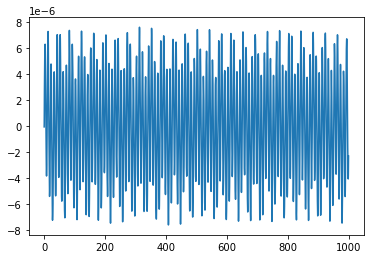

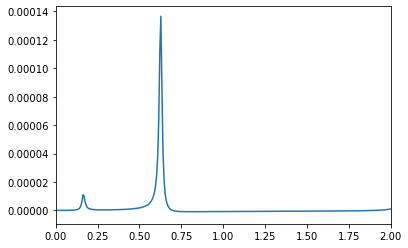

In [6]:
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag))
plt.xlim([0,2])
plt.show()

In [14]:
def LvN_dipoleRK2(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 2nd Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1A = -1j*(F_t_αe@DA_t - DA_t@F_t_αe) * dt
        K1B = -1j*(F_t_βe@DB_t - DB_t@F_t_βe) * dt
        
        P2A = DA_t + K1A
        P2B = DB_t + K1B
        
        # compute K2
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ P2A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P2B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2A = -1j*(F_t_αe@P2A - P2A@F_t_αe) * dt
        K2B = -1j*(F_t_βe@P2B - P2B@F_t_βe) * dt
        
        DA_t += (0.5) * (K1A + K2A) 
        DB_t += (0.5) * (K1B + K2B)

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

100%|██████████| 500000/500000 [03:17<00:00, 2535.75it/s]


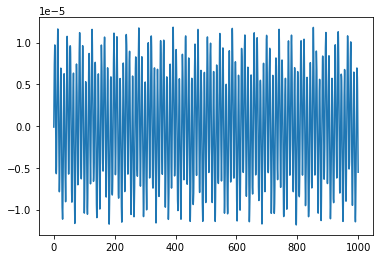

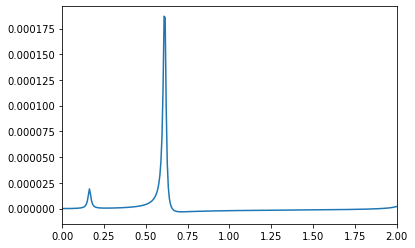

In [13]:
t, d_tx = LvN_dipoleRK2(asd, dt = 0.002, dT =1000, field=field3)
plt.plot(t, d_tx[:,2])
plt.show()

ω, d_ωx = RT_FFT(t, d_tx, Γ=0.01)
plt.plot(ω, -np.einsum("w, wx -> w", ω, d_ωx.imag))
plt.xlim([0,2])
plt.show()